In [1]:
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import matplotlib.pyplot as plt

# Utils

In [ ]:
def post_process_text(text):
    text = text.lower()
    pattern = re.compile('[\W_]+')
    text = pattern.sub('', text)
    return text

In [71]:
def crop_img(image, box):
    startX, startY, endX, endY = box
    return image[startY:endY, startX:endX,:]

In [ ]:
def show_image(image, text):
    cv2.imshow(text, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Text Detection With EAST

In [3]:
def text_detection_correction(**kwarg):
    #startX correction
    if kwarg['startX']<0:
        startX=0
    else:
        startX = kwarg['startX']
    #startY correction
    if kwarg['startY']<0:
        startY=0
    else:
        startY = kwarg['startY']
    #endX correction
    if kwarg['endX']>kwarg['W']:
        endX=0
    else:
        endX = kwarg['endX']
    #endY correction
    if kwarg['endY']>kwarg['H']:
        endY=0
    else:
        endY = kwarg['endY']
    return (startX, startY, endX, endY)

In [4]:
def text_detection(image, east_model, min_confidence, width, height):
    start = time.time()
    # load the input image and grab the image dimensions
    orig = image.copy()
    (H, W) = image.shape[:2]
    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (width, height)
    rW = W / float(newW)
    rH = H / float(newH)
    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]
    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]
    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    east_model.setInput(blob)
    (scores, geometry) = east_model.forward(layerNames)
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < min_confidence:
                continue
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            (startX, startY, endX, endY) = text_detection_correction(
                startX=startX, startY=startY, endX=endX, endY=endY, H=H, W=W
            )
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    orig_boxes = []
    for i,(startX, startY, endX, endY) in enumerate(boxes):
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        orig_boxes.append((startX, startY, endX, endY))
    end = time.time()
    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))
    return orig_boxes

In [23]:
def show_detected_img(img, boxes):
    fig, axs = plt.subplots(nrows=1, ncols=len(boxes), figsize=(15,10))
    for i,(startX, startY, endX, endY) in enumerate(boxes):
        if len(boxes)==1:
            axs.imshow(img[startY:endY, startX:endX,:])
        else:
            axs[i].imshow(img[startY:endY, startX:endX,:])

In [60]:
img_path = 'dataset/test_ocr.png'
east_path = 'models/frozen_east_text_detection.pb'
min_confidence = 0.5
east_width = 320#need to be multiple of 32
east_height = 320#need to be multiple of 32

In [61]:
east_model = cv2.dnn.readNet(east_path)

[INFO] text detection took 0.122251 seconds


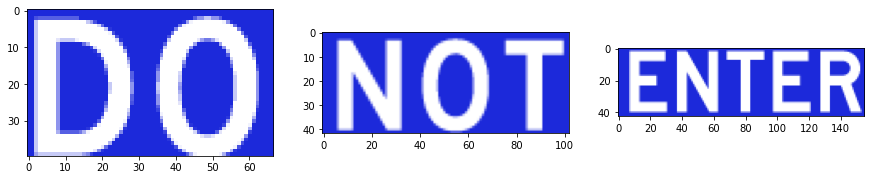

In [34]:
img_path = 'example_images/test_ocr.png'
img = cv2.imread(img_path)
text_detection_boxes = text_detection(img, east_model, min_confidence, width, height)
fig, axs = plt.subplots(nrows=1, ncols=len(text_detection_boxes), figsize=(15,10))
for i,(startX, startY, endX, endY) in enumerate(text_detection_boxes):
	if len(text_detection_boxes)==1:
		axs.imshow(img[startY:endY, startX:endX,:])
	else:
		axs[i].imshow(img[startY:endY, startX:endX,:])

# OCR Per-word With pytesseract

In [5]:
import pytesseract
from PIL import Image
import re
import string

In [6]:
#init with tesseract exe file location
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [7]:
def preprocess_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    return img

In [19]:
def ocr_with_tesseract(**kwarg):
    start = time.time()
    text_detection_boxes =  text_detection(kwarg['img'], kwarg['east_model'], kwarg['min_confidence'], kwarg['width'], kwarg['height'])
    configuration = kwarg['tesseract_config']
    texts=[]
    for (startX, startY, endX, endY) in (text_detection_boxes):
        try:
            text = pytesseract.image_to_string(img[startY:endY, startX:endX], config=configuration).split()[0]
            text = post_process_text(text)
            texts.append(text)
        except:
            texts.append("")
    texts = " ".join(texts)
    end = time.time()
    print(texts)
    print(f'[INFO] OCR with tesseract took {end-start} seconds')
    

In [16]:
#init only run once
img_path = 'dataset/indomaret.jpg'
east_path = 'models/frozen_east_text_detection.pb'
min_confidence = 0.5
width = 320#need to be multiple of 32
height = 320#need to be multiple of 32
tesseract_config =("-l ind --oem 1 --psm 8")
east_model = cv2.dnn.readNet(east_path)

In [20]:
img_path = 'example_images/google.png'
img = cv2.imread(img_path)
ocr_with_tesseract(img=img, east_model=east_model, min_confidence=min_confidence, width=width, height=height, tesseract_config = tesseract_config)

[INFO] text detection took 0.146303 seconds
google
[INFO] OCR with tesseract took 0.2593197822570801 seconds


In [24]:
img_path = 'example_images/buku_indo.jpg'
img = cv2.imread(img_path)
ocr_with_tesseract(img=img, east_model=east_model, min_confidence=min_confidence, width=width, height=height, tesseract_config = tesseract_config)

[INFO] text detection took 0.144491 seconds
perguru urikulum jindonesif bahasa ideas kuliah tinggi mata nanas gn herman  5 wanib ar penulis sayamal  i 1 n malabar
[INFO] OCR with tesseract took 2.5204367637634277 seconds


In [25]:
img_path = 'example_images/watson.jpg'
img = cv2.imread(img_path)
ocr_with_tesseract(img=img, east_model=east_model, min_confidence=min_confidence, width=width, height=height, tesseract_config = tesseract_config)

[INFO] text detection took 0.125521 seconds
wolsons  sd
[INFO] OCR with tesseract took 0.4130668640136719 seconds


# Using CRNN

In [31]:
import argparse
from pathlib import Path

import yaml
import tensorflow as tf
from tensorflow import keras

In [38]:
def read_img_and_resize(img, shape):
    # img = tf.io.read_file(path)
    # img = tf.io.decode_jpeg(img, channels=shape[2])
    if shape[1] is None:
        img_shape = tf.shape(img)
        scale_factor = shape[0] / img_shape[0]
        img_width = scale_factor * tf.cast(img_shape[1], tf.float64)
        img_width = tf.cast(img_width, tf.int32)
    else:
        img_width = shape[1]
    img = tf.image.resize(img, (shape[0], img_width))
    return img

In [78]:
def tf_model_inference(model, img):
    outputs = model(img)
    text, prob = outputs[0].numpy()[0].decode("utf-8") , outputs[1].numpy()[0]
    if prob<0.5:
        text = ""
    return text

In [81]:
def ocr_with_crnn(**kwarg):
    start = time.time()
    text_detection_boxes =  text_detection(kwarg['img'], kwarg['east_model'], kwarg['min_confidence'], 
                                           kwarg['east_width'], kwarg['east_height'])
    texts = []
    for box in text_detection_boxes:
        cropped_img = crop_img(img, box)
        cropped_img = read_img_and_resize(cropped_img, kwarg['config']['img_shape'])
        cropped_img = tf.expand_dims(cropped_img, 0)
        text = tf_model_inference(kwarg['tf_model'], cropped_img)
        text = post_process_text(text)
        texts.append(text)
    end = time.time()
    print(f'OCR with CRNN took {end-start} seconds')
    return " ".join(texts)

In [ ]:
with open("configs\mjsynth.yml", "r") as stream:
    try:
        config = yaml.safe_load(stream)['dataset_builder']
    except yaml.YAMLError as exc:
        print(exc)

In [57]:
model_path = 'models/SavedModel/'
crnn = keras.models.load_model(model_path, compile=False)

In [83]:
img_path = 'example_images/buku_indo.jpg'
img = cv2.imread(img_path)
texts = ocr_with_crnn(
    img=img, east_model=east_model, min_confidence=min_confidence, east_width=east_width, east_height=east_height,
    config = config, tf_model = crnn
)
print(texts)

[INFO] text detection took 0.166114 seconds
OCR with CRNN took 1.7352619171142578 seconds
perguru urikulum indonesic bahosa ideas kuhah tinggil    herman   warib  penulis sayama imoh  idakian  amalabar


# OCR per Character with TFModel

only do character recognition and combine it into one word. We need EAST to extract per word

In [26]:
from src.model import OCRModel
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
import tensorflow as tf

In [28]:
def ocr_per_word(image, model_input_shape):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    contours, hierarchy  = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #combine contour and hierarchy for sorting
    cnts = []
    cnts.append(contours)
    cnts.append(hierarchy)
    cnts = tuple(cnts)
    #sort contours
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    #crop image based on contours
    chars = []
    areas=[]
    for i in range(0,len(cnts)):
        area=cv2.contourArea(cnts[i])
        areas.append(area)
        #if( area<20000 and area>5000):
        x,y,w,h= cv2.boundingRect(cnts[i])
        cropped_img=image[y:y+h, x:x+w]
        cropped_img = cropped_img.astype("float32")/255
        cropped_img = cv2.resize(cropped_img, model_input_shape)
        chars.append(cropped_img)
    return np.asarray(chars), np.asarray(areas)

In [29]:
def model_inference(chars, model):
    labelNames = "0123456789"
    labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    labelNames = [l for l in labelNames]
    preds = model.model.predict(chars)
    text=""
    label_idx = []
    for i,pred in enumerate(preds):
        pred_max = np.max(pred)
        if pred_max>0.6:
            label = labelNames[np.argmax(pred)]
            text+= label
            label_idx.append(i)
    return text, label_idx

In [30]:
img_path = 'dataset/test_ocr.png'
east_path = 'models/frozen_east_text_detection.pb'
ocr_model_path = 'models/mobilenet_0/cp.ckpt'
model = OCRModel(3)
model.load(model_type='mobilenet', model_path=ocr_model_path)
east_model = cv2.dnn.readNet(east_path)
min_confidence = 0.5
width = 320#need to be multiple of 32
height = 320#need to be multiple of 32
model_height_inp = 32
model_width_inp = 32
ocr_threshold = 0.7

ValueError: Exception encountered when calling layer "conv2d_29" "                 f"(type Conv2D).

Negative dimension size caused by subtracting 3 from 1 for '{{node inception_v3/conv2d_29/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true](inception_v3/activation_28/Relu, inception_v3/conv2d_29/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,96], [3,3,96,96].

Call arguments received by layer "conv2d_29" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 96), dtype=float32)

Define the model

In [55]:
model = OCRModel(1)
model.load(model_type='efficientnet', model_path='models/efficientnet_0/cp.ckpt')

[INFO] initializing model took 1.4924838542938232 seconds
[INFO] loading the model took 5.496660947799683 seconds


Do the OCR

In [14]:
#config
model_input_shape = (32,32)
img_path = 'example_images/test_ocr2.png'
#text detection
image = cv2.imread(img_path)
text_detection_boxes = text_detection(image, east_model, min_confidence, width, height)
#ocr per character
texts = ""
for box in text_detection_boxes:
    cropped = crop_img(image, box)
    chars,_ = ocr_per_word(cropped, model_input_shape)
    text, label_idx = model_inference(chars, model)
    texts+=f'{text} '

[INFO] text detection took 0.144526 seconds


NameError: name 'crop_img' is not defined

kalau mau satu2

In [181]:
#config
model_input_shape = (32,32)
img_path = 'example_images/test_ocr2.png'
#text detection
image = cv2.imread(img_path)
text_detection_boxes = text_detection(image, east_model, min_confidence, width, height)
box = text_detection_boxes[0]
cropped = crop_img(image, box)
chars,areas = ocr_per_word(cropped, model_input_shape)
text, label_idx = model_inference(chars, model)
print(text)

[INFO] text detection took 0.110951 seconds
1/1 [==============================] - 0s 29ms/step
CC


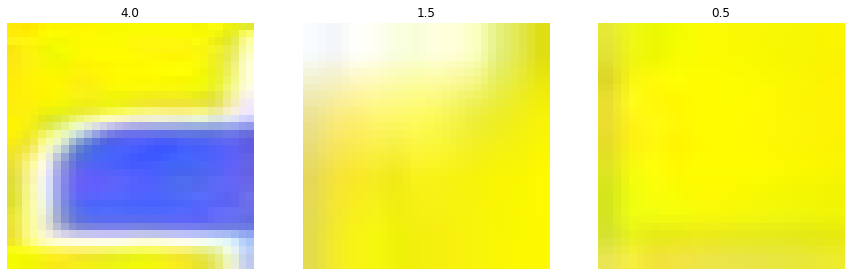

In [175]:
fig, axs = plt.subplots(ncols=len(label_idx), nrows=1, figsize=(15,10))
for i in range(len(label_idx)):
    axs[i].imshow(chars[label_idx[i]])
    axs[i].set_title(areas[label_idx[i]])
    axs[i].axis('off')

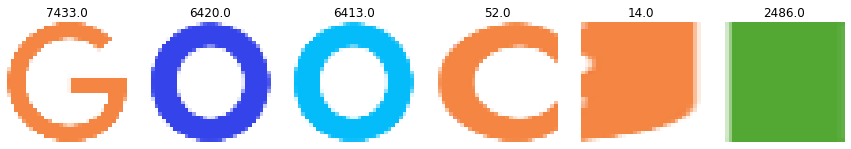

In [178]:
fig, axs = plt.subplots(ncols=len(label_idx), nrows=1, figsize=(15,10))
for i in range(len(label_idx)):
    axs[i].imshow(chars[label_idx[i]])
    axs[i].set_title(areas[label_idx[i]])
    axs[i].axis('off')

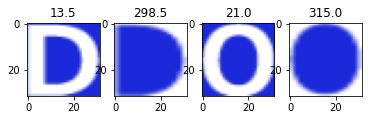

In [146]:
fig, axs = plt.subplots(ncols=len(chars), nrows=1)
for i in range(len(chars)):
    axs[i].imshow(chars[i])
    axs[i].set_title(areas[i])
    axs[i].axis('off')

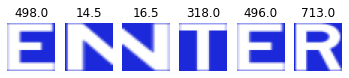

In [151]:
fig, axs = plt.subplots(ncols=len(chars), nrows=1)
for i in range(len(chars)):
    axs[i].imshow(chars[i])
    axs[i].set_title(areas[i])
    axs[i].axis('off')

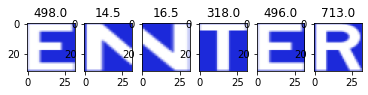

In [150]:
fig, axs = plt.subplots(ncols=len(chars), nrows=1)
for i in range(len(chars)):
    axs[i].imshow(chars[i])
    axs[i].set_title(areas[i])

In [79]:
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
contours, hierarchy  = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

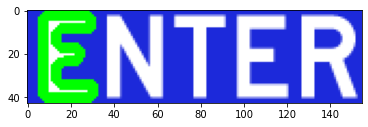

In [89]:
img_copy = cropped.copy()
img_copy=cv2.drawContours(img_copy, contours, 5, (0,255,0), 3)
plt.imshow(img_copy)

In [83]:
len(contours)

6